<a href="https://colab.research.google.com/github/NicoPP1/PDI/blob/main/TP6/TP6Parma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico Nº6 Procesamiento Digital de Imágenes - Convolución
### Autor: Nicolás Daniel Parma Paternostro
### Consigna: 

Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:

1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4

Respecto del “cierre” de la imagen cerca de los bordes, implementar la técnica no matemáticamente perfecta de “repetir” artificialmente filas o columnas cuando estas hagan falta. Por ejemplo, si el kernel es 3x3 y estoy en la primera columna, y no hay ninguna columna a la izquierda, entonces repito la primera columna como si estuviese en la imagen original. Otra opción es la conocida como padding en la cual adicionamos filas y columnas de ceros en los extremos de la imagen, similar al que les mostré para hacer que dos imágenes tengan el mismo tamaño.

Deben mostrar el aplicativo que permita cargar o seleccionar la imagen y elegir de una lista el filtro a aplicar ver su resultado. Adicionalmente deben mostrar un plot con todos los filtros aplicados para la imagen de entrada.

Nota: La función de convolución debe ser desarrollada por ustedes, NO mediante funciones de biblioteca.


### Fecha de Entrega: 05 de noviembre 2021

###Librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

###Funciones para trabajar en los espacios RGB e YIQ

In [2]:
#Función para clipear la luminancia
def clipY(mat):
    mat = np.clip(mat,0.0,1.0)
    return mat

#Función para clipear la componente en fase
def clipI(mat):
    mat = np.clip(mat,-0.5957,0.5957)          
    return mat

#Función para clipear la el componente en cuadratura
def clipQ(mat):
    mat = np.clip(mat,-0.5226,0.5226)          
    return mat

#Función para obtener componentes RGB de una imagen y devolverlo en el espacio YIQ
def RGB2YIQ(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r,g,b = RGB(img)
    r = r/255 #normalizo canales
    g = g/255 #normalizo canales
    b = b/255 #normalizo canales

    Y = (r*0.299+g*0.587+b*0.114)
    I = (r*0.595716-g*0.274453-b*0.321263)
    Q = (r*0.211456-g*0.522591+b*0.311135)

    return(Y,I,Q)

#Función para obtener los canales RGB de una imagen
def RGB(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    return r,g,b

#Función para obtener una imagen RGB a partir de los componentes YIQ modificadas
def YIQ2RGB(Y,I,Q):
    Y = clipY(Y) #función para clipear luminancia
    I = clipI(I) #función para clipear luminancia
    Q = clipQ(Q) #función para clipear luminancia

    dimension = Y.shape

    r = np.zeros((dimension[0],dimension[1]), dtype = float)
    g = np.zeros((dimension[0],dimension[1]), dtype = float)
    b = np.zeros((dimension[0],dimension[1]), dtype = float)

    r = (Y+0.9563*I+0.621*Q)*255
    g = (Y-0.2721*I-0.6474*Q)*255
    b = (Y-1.1070*I+1.7046*Q)*255

    r = np.clip(r,0,255)
    g = np.clip(g,0,255)
    b = np.clip(b,0,255)

    img = np.zeros((dimension[0],dimension[1],3),dtype = 'uint8') #Transformo a tipo de dato uint8 ya que es el requerido para mostrar las imágenes
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b

    return(img)

### Función para cargar el kernel que sea requerido por el usuario

In [3]:
def cargaKernels(k):
    if k == "plano3":
        kernel = (1/9)*np.ones((3,3))
    elif k == "plano5":
        kernel = (1/25)*np.ones((5,5), dtype = 'float64')
    elif k == "plano7":
        kernel = (1/49)*np.ones((7,7))

    elif k == "bartlett3":
        kernel  = (1/16)*np.matrix('1 2 1; 2 4 2; 1 2 1')
    elif k == "bartlett5":
        kernel = (1/81)*np.matrix('1 2 3 2 1 ; 2 4 6 4 2; 3 6 9 6 3; 2 4 6 4 2 ; 1 2 3 2 1')
    elif k == "bartlett7":
        kernel = (1/256)*np.matrix('1 2 3 4 3 2 1; 2 4 6 8 6 4 2; 3 6 9 12 9 6 3; 4 8 12 16 12 8 4; 3 6 9 12 9 6 3; 1 2 3 4 3 2 1; 2 4 6 8 6 4 2')

    elif k == "gaussiano5":
        kernel = (1/256)*np.matrix('1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1')
    elif k == "gaussiano7":
        kernel = (1/4096)*np.matrix('1 6 15 20 15 6 1; 6 36 90 120 90 36 6; 15 90 225 300 225 90 15; 20 120 300 400 300 120 20; 15 90 225 300 225 90 15; 6 36 90 120 90 36 6; 1 6 15 20 15 6 1')
   
    elif k == "laplacianov4":
        kernel = np.matrix('0 -1 0; -1 4 -1; 0 -1 0')
    elif k == "laplacianov8":
        kernel = np.matrix('-1 -1 -1; -1 8 -1; -1 -1 -1')

    elif k == "sobelN":
        kernel = np.matrix('-1 -2 -1; 0 0 0; 1 2 1')
    elif k == "sobelNE":
        kernel = np.matrix('0 -1 -2; 1 0 -1; 2 1 0')
    elif k == "sobelE":
        kernel = np.matrix('1 0 -1; 2 0 -2; 1 0 -1')
    elif k == "sobelSE":
        kernel = np.matrix('2 1 0;1 0 -1; 0 -1 -2')

    elif k == "sobelS":
        kernel = np.matrix('1 2 1; 0 0 0; -1 -2 -1')
    elif k == "sobelSW":
        kernel = np.matrix('0 1 2; -1 0 1; -2 -1 0')
    elif k == "sobelW":
        kernel = np.matrix('-1 0 1;-2 0 2; -1 0 1')
    elif k == "sobelNW":
        kernel = np.matrix('-2 -1 0;-1 0 1; 0 1 2')
    elif k == "pasaaltos02":
        kernel = np.matrix('1 -4 6 -4 1; -4 16 -24 16 -4; 6 -24 36 -24 6; -4 16 -24 16 -4; 1 -4 6 -4 1')
    elif k == "pasaaltos04":
        kernel = np.matrix('1 4 -10 4 1;4 16 -40 16 4;-10 -40 100 -40 -10; 4 16 -40 16 4;1 4 -10 4 1')
    elif k == "pasabanda":
        kernel = np.matrix('1 0 -2 0 1; 0 0 0 0 0; -2 0 4 0 -2; 0 0 0 0 0 ; 1 0 -2 0 1')  
  
    return kernel

### Función para realizar la convolución a partir de la luminancia de una imagen y el kernel de un filtro deseado


In [4]:
def convo(Y,kernel):
    shapeY = Y.shape
    heightY = shapeY[0]
    widthY = shapeY[1]


    shapeKernel = kernel.shape
    heightKernel = shapeKernel[0]
    widthKernel = shapeKernel[1]

    Yconv = np.zeros((heightY,widthY))

    #Según el tamaño del kernel, es distinto el padding de ceros a realizar
    if kernel.shape[0] == 3:
        Ypad = np.zeros((heightY+2,widthY+2))
        Ypad[1:heightY+1,1:widthY+1] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))

                
        Yconv = np.clip(Yconv,0,1)

        
    elif kernel.shape[0] == 5:
        Ypad = np.zeros((heightY+4,widthY+4))
        Ypad[2:heightY+2,2:widthY+2] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))
                
        Yconv = np.clip(Yconv,0,1)

        
        
    elif kernel.shape[0] == 7:
        Ypad = np.zeros((heightY+6,widthY+6))
        Ypad[3:heightY+3,3:widthY+3] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))
                
        Yconv = np.clip(Yconv,0,1)
        
    else:
        print('filtro de orden incorrecto')

    return Yconv

### Aplicativo que permite ingresar el URL de una imagen deseada, seleccionar el filtro a aplicar y realizar la convolución del mismo con la imagen deseada (Se trabaja con la luminancia de la misma)

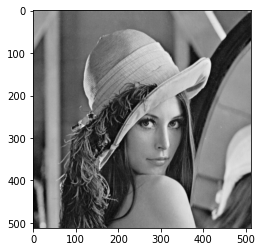

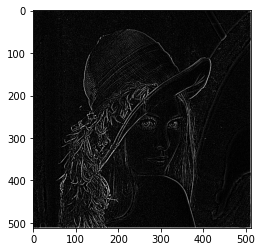

In [5]:
#@title Ingrese la URL de la imagen deseada y luego seleccione el filtro a realizar { run: "auto", vertical-output: true }
url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" #@param {type:"string"}
img = imageio.imread(url)
#@title  { run: "auto", vertical-output: true }
k = "laplacianov8" #@param ["plano3", "plano5", "plano7", "bartlett3", "bartlett5", "bartlett7", "gaussiano5", "gaussiano7", "laplacianov4", "laplacianov8", "sobelN", "sobelNE", "sobelE", "sobelSE", "sobelS", "sobelSW", "sobelW", "sobelNW", "pasaaltos02", "pasaaltos04", "pasabanda"]
Y,I,Q = RGB2YIQ(img)
kernel = cargaKernels(k)
Yconv = convo(Y,kernel)

plt.figure(1)
plt.imshow(Y,'gray')

plt.figure(2)
plt.imshow(Yconv,'gray')

### Aplico todos los filtros a la imagen anterior para poder visualizar los efectos de cada filtro en particular sobre la imagen

In [6]:
Y,I,Q = RGB2YIQ(img)

Yplano3 = convo(Y,cargaKernels('plano3'))
Yplano5 = convo(Y,cargaKernels('plano5'))
Yplano7 = convo(Y,cargaKernels('plano7'))

Ybart3 = convo(Y,cargaKernels('bartlett3'))
Ybart5 = convo(Y,cargaKernels('bartlett5'))
Ybart7 = convo(Y,cargaKernels('bartlett7'))

Ygauss5 = convo(Y,cargaKernels('gaussiano5'))
Ygauss7 = convo(Y,cargaKernels('gaussiano7'))

Ylap4 =  convo(Y,cargaKernels('laplacianov4'))
Ylap8 =  convo(Y,cargaKernels('laplacianov8'))

YsobelN = convo(Y,cargaKernels('sobelN'))
YsobelNE = convo(Y,cargaKernels('sobelNE'))
YsobelE = convo(Y,cargaKernels('sobelE'))
YsobelSE = convo(Y,cargaKernels('sobelSE'))

YsobelS = convo(Y,cargaKernels('sobelS'))
YsobelSW = convo(Y,cargaKernels('sobelSW'))
YsobelW = convo(Y,cargaKernels('sobelW'))
YsobelNW = convo(Y,cargaKernels('sobelNW'))

Yhighpass02 = convo(Y,cargaKernels('pasaaltos02'))
Yhighpass04 = convo(Y,cargaKernels('pasaaltos04'))
Ybandpass = convo(Y,cargaKernels('pasabanda'))

### Visualización de los distintos filtros

Text(0.5, 1.0, 'Pasa banda (Diferencia de Gaussianas)')

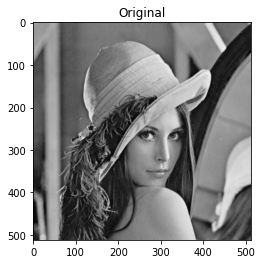

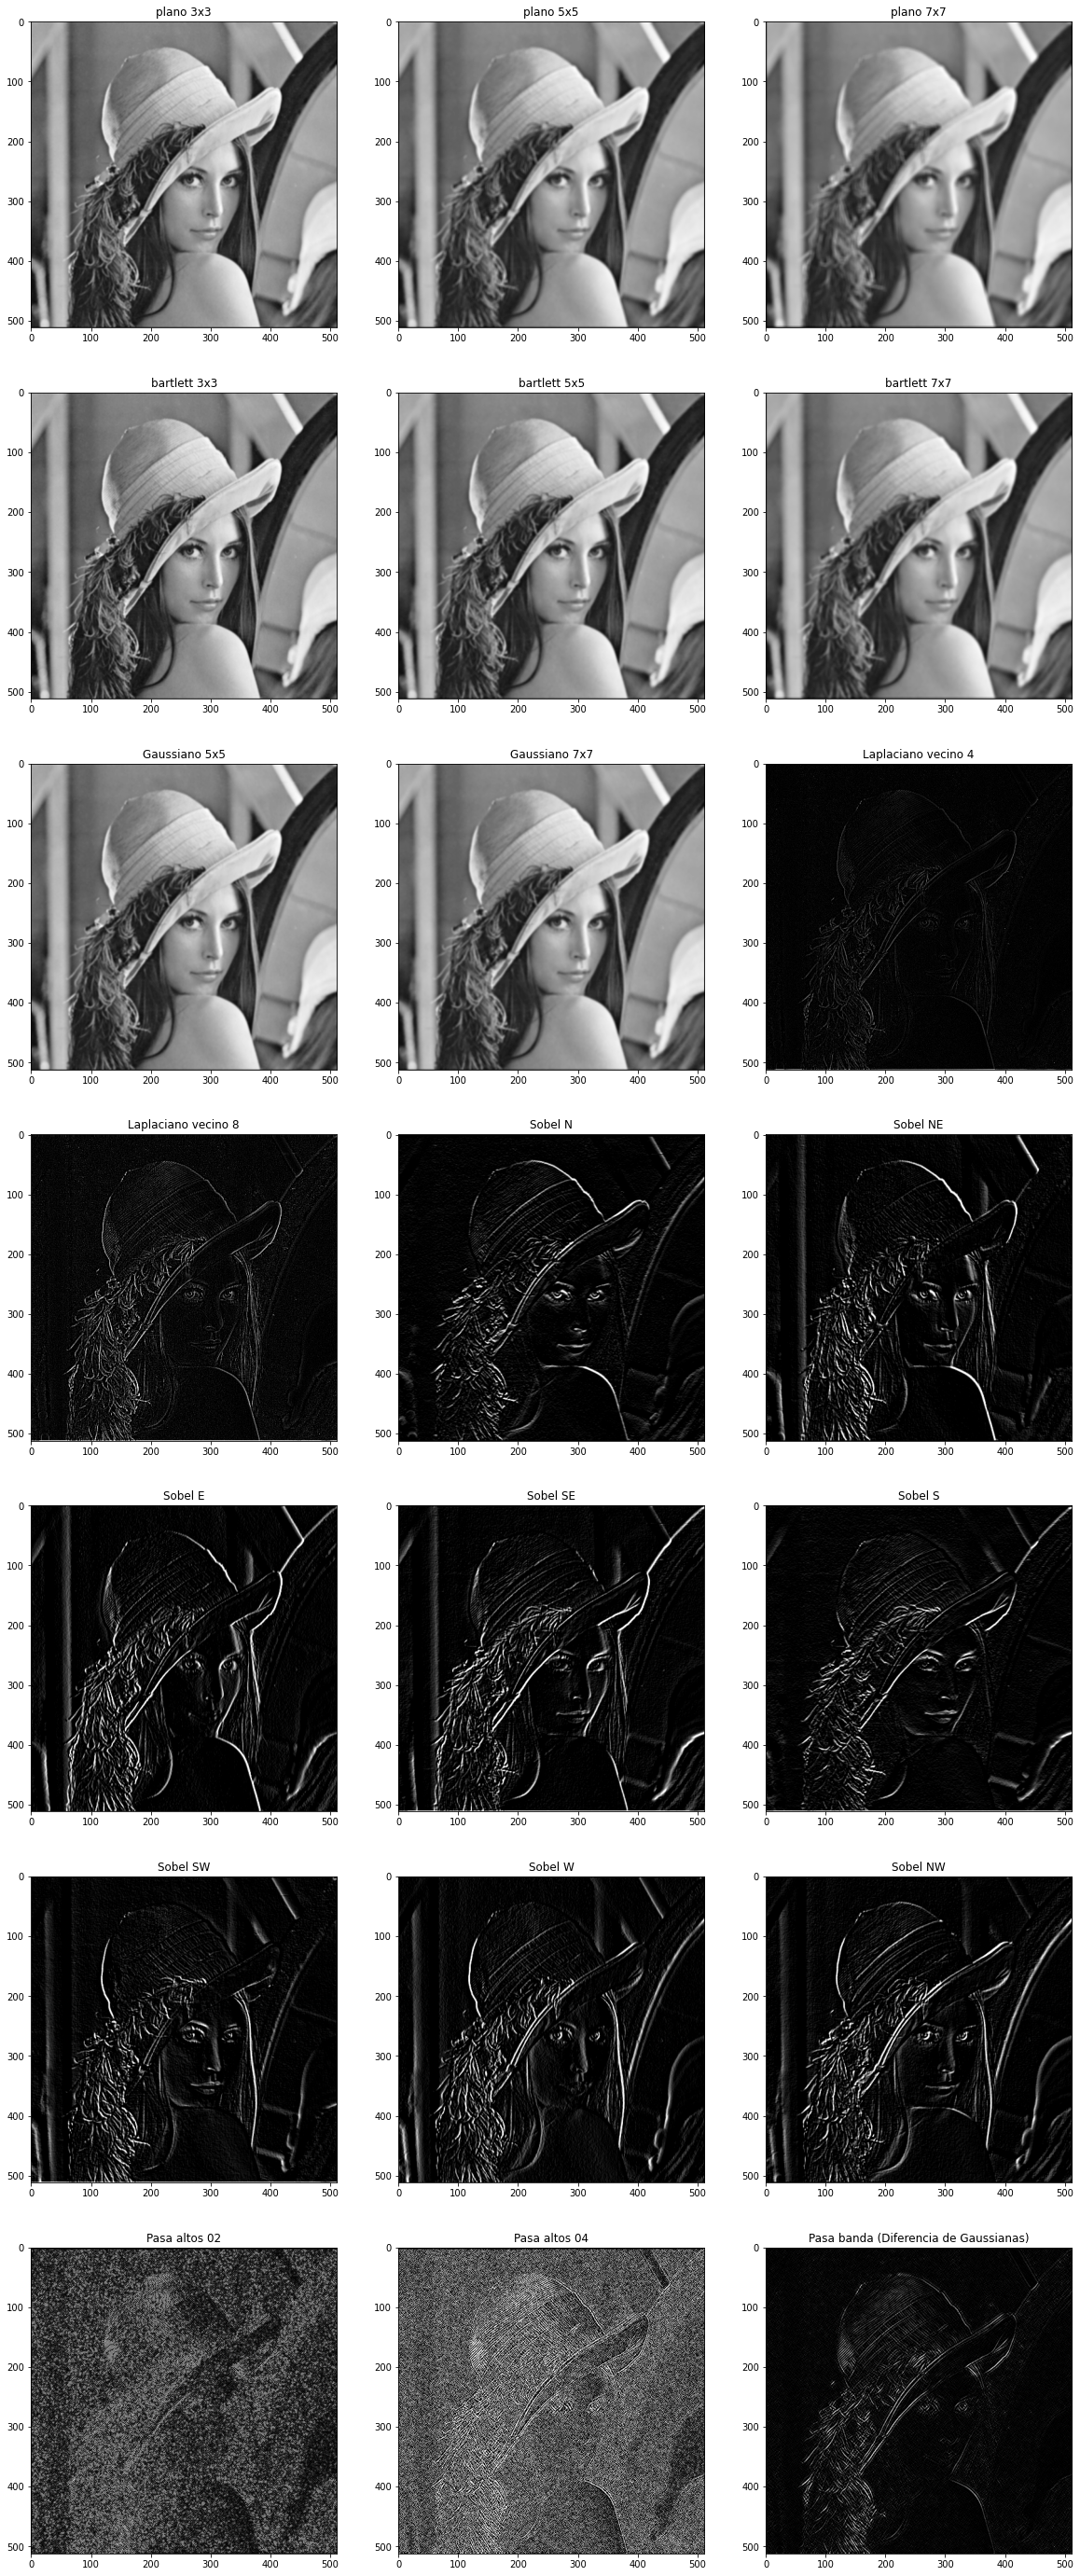

In [7]:
plt.figure(0)
plt.imshow(Y,'gray')
plt.title('Original')

fig,ax = plt.subplots(7,3)
fig.set_size_inches(20, 50)

ax[0,0].imshow(Yplano3,'gray')
ax[0,0].set_title('plano 3x3')
ax[0,1].imshow(Yplano5,'gray')
ax[0,1].set_title('plano 5x5')
ax[0,2].imshow(Yplano7,'gray')
ax[0,2].set_title('plano 7x7')

ax[1,0].imshow(Ybart3,'gray')
ax[1,0].set_title('bartlett 3x3')
ax[1,1].imshow(Ybart5,'gray')
ax[1,1].set_title('bartlett 5x5')
ax[1,2].imshow(Ybart7,'gray')
ax[1,2].set_title('bartlett 7x7')

ax[2,0].imshow(Ygauss5,'gray')
ax[2,0].set_title('Gaussiano 5x5')
ax[2,1].imshow(Ygauss7,'gray')
ax[2,1].set_title('Gaussiano 7x7')
ax[2,2].imshow(Ylap4,'gray')
ax[2,2].set_title('Laplaciano vecino 4')

ax[3,0].imshow(Ylap8,'gray')
ax[3,0].set_title('Laplaciano vecino 8')
ax[3,1].imshow(YsobelN,'gray')
ax[3,1].set_title('Sobel N')
ax[3,2].imshow(YsobelNE,'gray')
ax[3,2].set_title('Sobel NE')

ax[4,0].imshow(YsobelE,'gray')
ax[4,0].set_title('Sobel E')
ax[4,1].imshow(YsobelSE,'gray')
ax[4,1].set_title('Sobel SE')
ax[4,2].imshow(YsobelS,'gray')
ax[4,2].set_title('Sobel S')

ax[5,0].imshow(YsobelSW,'gray')
ax[5,0].set_title('Sobel SW')
ax[5,1].imshow(YsobelW,'gray')
ax[5,1].set_title('Sobel W')
ax[5,2].imshow(YsobelNW,'gray')
ax[5,2].set_title('Sobel NW')

ax[6,0].imshow(Yhighpass02,'gray')
ax[6,0].set_title('Pasa altos 02')
ax[6,1].imshow(Yhighpass04,'gray')
ax[6,1].set_title('Pasa altos 04')
ax[6,2].imshow(Ybandpass,'gray')
ax[6,2].set_title('Pasa banda (Diferencia de Gaussianas)')

### Aplico los filtros pasa altos, sobel y pasa banda sobre la imagen de un octógono para un mayor entendimiento de estos filtros (cargar imagen mediante el botón upload file y seleccionar la imagen adjunta mediante el formulario de google)

In [9]:
img = imageio.imread('/content/oct.bmp')
Y,I,Q = RGB2YIQ(img)

Ylap4 =  convo(Y,cargaKernels('laplacianov4'))
Ylap8 =  convo(Y,cargaKernels('laplacianov8'))

YsobelN = convo(Y,cargaKernels('sobelN'))
YsobelNE = convo(Y,cargaKernels('sobelNE'))
YsobelE = convo(Y,cargaKernels('sobelE'))
YsobelSE = convo(Y,cargaKernels('sobelSE'))

YsobelS = convo(Y,cargaKernels('sobelS'))
YsobelSW = convo(Y,cargaKernels('sobelSW'))
YsobelW = convo(Y,cargaKernels('sobelW'))
YsobelNW = convo(Y,cargaKernels('sobelNW'))

Yhighpass02 = convo(Y,cargaKernels('pasaaltos02'))
Yhighpass04 = convo(Y,cargaKernels('pasaaltos04'))
Ybandpass = convo(Y,cargaKernels('pasabanda'))

### Visualización de los distintos filtros para la imagen del octógono

Text(0.5, 1.0, 'Pasa banda')

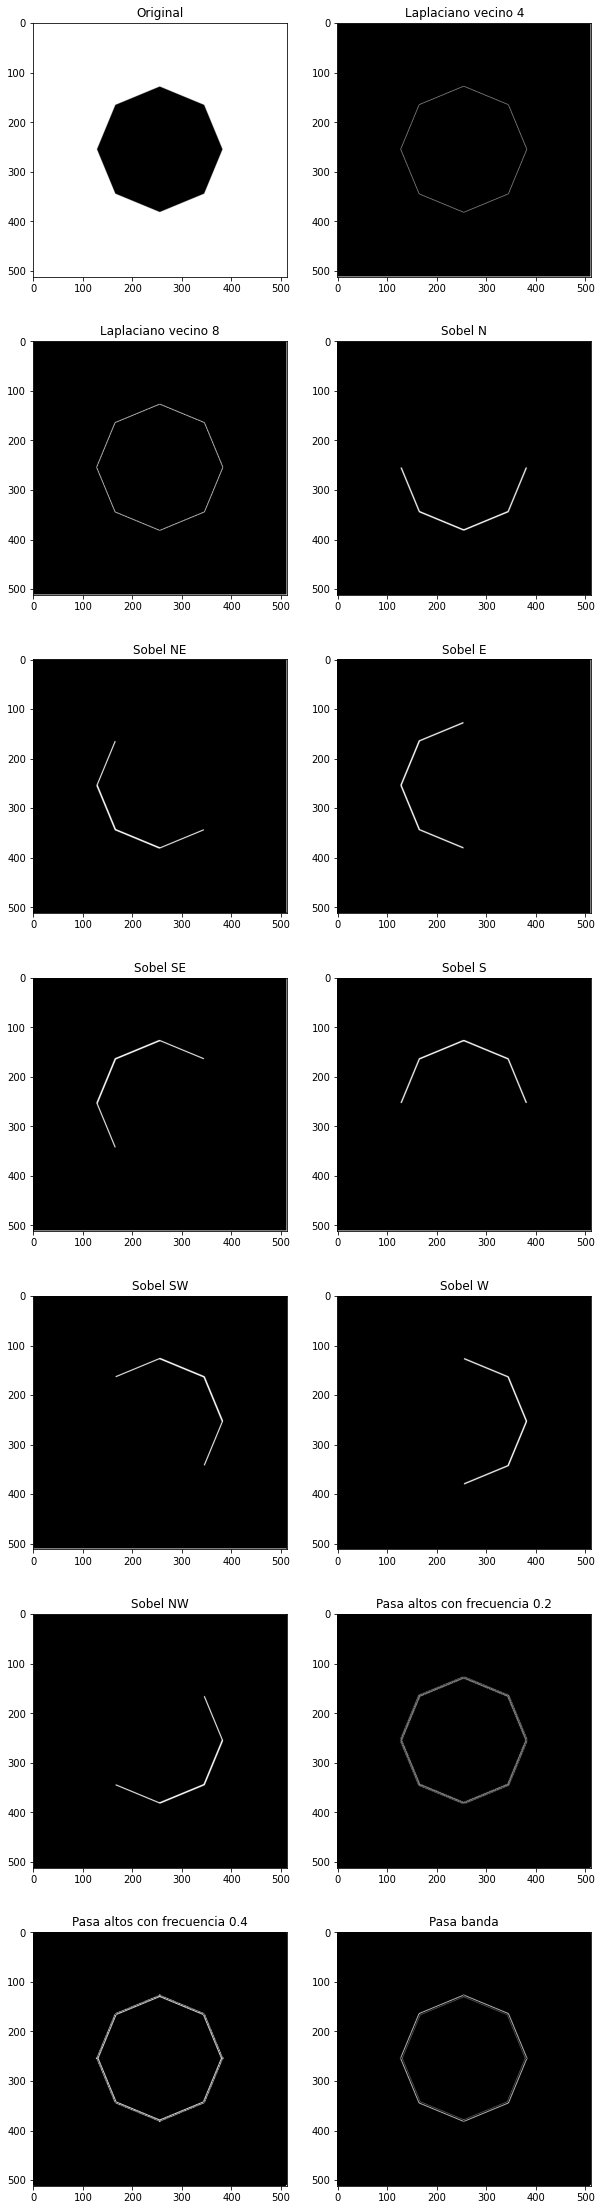

In [10]:
fig,ax = plt.subplots(7,2)
fig.set_size_inches(10, 40)

ax[0,0].imshow(Y,'gray')
ax[0,0].set_title('Original')
ax[0,1].imshow(Ylap4,'gray')
ax[0,1].set_title('Laplaciano vecino 4')

ax[1,0].imshow(Ylap8,'gray')
ax[1,0].set_title('Laplaciano vecino 8')
ax[1,1].imshow(YsobelN,'gray')
ax[1,1].set_title('Sobel N')

ax[2,0].imshow(YsobelNE,'gray')
ax[2,0].set_title('Sobel NE')
ax[2,1].imshow(YsobelE,'gray')
ax[2,1].set_title('Sobel E')

ax[3,0].imshow(YsobelSE,'gray')
ax[3,0].set_title('Sobel SE')
ax[3,1].imshow(YsobelS,'gray')
ax[3,1].set_title('Sobel S')

ax[4,0].imshow(YsobelSW,'gray')
ax[4,0].set_title('Sobel SW')
ax[4,1].imshow(YsobelW,'gray')
ax[4,1].set_title('Sobel W')

ax[5,0].imshow(YsobelNW,'gray')
ax[5,0].set_title('Sobel NW')
ax[5,1].imshow(Yhighpass02,'gray')
ax[5,1].set_title('Pasa altos con frecuencia 0.2')

ax[6,0].imshow(Yhighpass04,'gray')
ax[6,0].set_title('Pasa altos con frecuencia 0.4')
ax[6,1].imshow(Ybandpass,'gray')
ax[6,1].set_title('Pasa banda')

# Análisis de resultados


Conociendo la teoría de la convolución, se pudo desarrollar una función que realice dicha operación trabajando a nivel de pixel de la imagen. Un incoveniente que surgió fue el hecho de que el operador "*" realiza el producto matricial, por lo que al utilizarlo el resultado no era el deseado. Para solucionar dicho incoveniente, se utilizó la función np.multiply la cual realiza el producto elemento a elemento.

Para analizar los filtros Plano, Bartlett y Guassiano se observarán la imagen de Lenna. Tanto el filtro plano como bartlett de 3x3 exhibe un menor desenfoque que su version de 5x5 y a su vez, este último un menor desenfoque que su versión 7x7. Esto es debido a que en estos últimos la cantidad de píxeles promediados aumenta, por lo que el desenfoque aumenta. A su vez, las diferencias entre los filtros Gaussiano, Plano y Barlett de las mismas dimensiones muestran muy pocas diferencias, pareciendo el filtro plano tener un mayor desenfoque, mientras que los otros dos (Bartlett y Gaussiano) una mayor suavidad al momento de realizar dichos filtrados. Esto es esperado debido al tipo de filtrado que se realiza en el caso Gaussiano, o en su aproximación con el filtro Barlett

Por otro lado, para el caso del filtro pasa altos y pasa banda se observará la imagen del octágono. Para el filtro detector de bordes laplaciano vecino 4, se observa que el mismo posee un borde de menor ancho que para el caso del filtro laplaciano de vecino 8. Esto se debe a que este último considera una mayor cantidad de píxeles que el primero (el primero toma en cuenta 5 píxeles mientras que este último considera 8).

En cuanto a los filtros Sobel, los mismos proveen una orientación correcta, detectando la arista que corresponde al filtro aplicado. Este resultado se puede ver claramente de la imagen del octágono.

El filtro pasa altos con frecuencia de corte 0.2 provee un borde menor que el de frecuencia de corte 0.4 para el caso de la imagen del octágono, lo cual era totalmente esperado ya que este último tiene un mayor rango en el cual las frecuencias pasan, ocasiando que el borde sea mayor. En cuanto a la imagen de lenna, se observa una mayor cantidad de detección de "bordes" para el caso del filtro con frecuencia de corte 0.4, lo cual es esperado ya que la frecuencia de corte es mayor, por lo que se deja pasar mayor cantidad de frecuencias. Cabe destacar que el efecto no es del todo esperado ya que se esperaba que el filtro laplaciano sea un efecto intermedio entre los dos filtros pasa altos, sin embargo esto no sucede ya que las imágenes filtradas con los filtros con frecuencia de corte 0.2 y 0.4 se ven muy ruidosas con respecto a la imagen filtrada mediante el uso del filtro laplaciano, tanto para sus versiones de vecino 4 como vecino 8.

Por último, con respecto al filtro pasa banda, en la imagen de Lenna se observa un rechazo de la alta y baja frecuencia, lo cual es esperado en este tipo de filtro.